In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw
import tensorflow_datasets as tfds


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
#load EMNIST data
dim_hor = 28
dim_ver = 28
dim = dim_hor * dim_ver

train_samples = 60000
emnist_train = tfds.as_numpy(tfds.load(name="emnist", split=tfds.Split.TRAIN))
x_train = np.stack([np.squeeze(next(emnist_train)['image']).T for i in range(train_samples)])
x_train = np.reshape(x_train, [-1, dim]).astype(np.float32) / 255
emnist_train = tfds.as_numpy(tfds.load(name="emnist", split=tfds.Split.TRAIN))
y_train = np.stack([next(emnist_train)['label'] for i in range(train_samples)])

test_samples = 10000
emnist_test = tfds.as_numpy(tfds.load(name="emnist", split=tfds.Split.TEST))
x_test = np.stack([np.squeeze(next(emnist_test)['image']).T for i in range(test_samples)])
x_test = np.reshape(x_test, [-1, dim]).astype(np.float32) / 255
emnist_test = tfds.as_numpy(tfds.load(name="emnist", split=tfds.Split.TEST))
y_test = np.stack([next(emnist_test)['label'] for i in range(test_samples)])

x_train.shape, y_train.shape, x_test.shape, y_test.shape

Instructions for updating:
Colocations handled automatically by placer.


W0720 09:58:23.455698 140393706350336 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


((60000, 784), (60000,), (10000, 784), (10000,))

In [3]:
#helper to show arrays of images
def imshow(img, draw=True):
    img = img.reshape([-1, 28, 28])
    out = np.empty([0, 280])
    for row in range((len(img) - 1) // 10 + 1):
        add = np.hstack(img[row * 10: row * 10 + 10])
        add = np.hstack([add, np.zeros([28, 280 - add.shape[1]])])
        out = np.vstack([out, add])
    if draw:
        fig = plt.figure(figsize=(20, 15))
        plt.imshow(out)
    else:
        return out

In [12]:
#model
tf.reset_default_graph()
sess = tf.InteractiveSession()


points = 25 #number of points to fit the image in
step_size = 3 #maximum velocity in pixels to move the marker  
varcoef = 0.01 #coefficient of the point size
epsilon = 0.0001 #fixing dividing by zero

X = tf.placeholder(tf.float32, [None, dim]) #input
Y_ = X #autoregression labels
L = X

#four layers of fully connected NN
L = tf.layers.Dense(units=600, activation=tf.nn.sigmoid)(L)
L = tf.layers.Dense(units=500, activation=tf.nn.sigmoid)(L)
L = tf.layers.Dense(units=400, activation=tf.nn.sigmoid)(L)
L = tf.layers.Dense(units=300, activation=tf.nn.sigmoid)(L)
#four output nodes (hor, ver velocity, size and intencity) as logits to use with possibly different activations
LOGITS = tf.layers.Dense(units=points * 4, activation=None)(L)

#reshape and activations
LOGITS_ver, LOGITS_hor, LOGITS_size, LOGITS_color = tf.split(tf.reshape(LOGITS, [-1, points, 4]), 4, axis=2)
#velocity in range -1:1
VELO_ver = tf.nn.tanh(LOGITS_ver) / dim_ver * step_size
VELO_hor = tf.nn.tanh(LOGITS_hor) / dim_hor * step_size
#position as an integral of velocity (we start from the middle left point)
POS_ver = 0.5 + tf.math.cumsum(VELO_ver, axis=1, exclusive=True)
POS_hor = 0.1 + tf.math.cumsum(VELO_hor, axis=1, exclusive=True)
#size and color intensity in range 0-1
POS_size = tf.nn.sigmoid(LOGITS_size)
POS_color = tf.nn.sigmoid(LOGITS_color)

#constant grid with gradients over coordinates
GRAD_ver = tf.tile(tf.expand_dims(tf.range(0., 1., 1. / dim_ver), axis=1), [1, dim_hor])
GRAD_hor = tf.tile(tf.expand_dims(tf.range(0., 1., 1. / dim_hor), axis=0), [dim_ver, 1])
#broadcasted marker point centers (gaussian means)
MEAN_ver = tf.tile(tf.expand_dims(POS_ver, axis=-1), [1, 1, dim_ver, dim_hor])
MEAN_hor = tf.tile(tf.expand_dims(POS_hor, axis=-1), [1, 1, dim_ver, dim_hor])
#broadcasted marker point size (gaussian variation)
VAR2 = tf.tile(tf.expand_dims(POS_size * varcoef + epsilon, axis=-1), [1, 1, dim_ver, dim_hor])
#broadcasted marker point color (gaussian amplitude)
AMP = tf.tile(tf.expand_dims(POS_color, axis=-1), [1, 1, dim_ver, dim_hor])
#gaussian marker points vector
MARKER = AMP * tf.exp((tf.square(GRAD_hor - MEAN_hor) + tf.square(GRAD_ver - MEAN_ver)) / -VAR2)

#head of the model - predict, loss, train step
Y = tf.reshape(tf.reduce_max(MARKER, axis=1), [-1, dim])
LOSS = tf.losses.mean_squared_error(Y_, Y)
TRAIN = tf.train.AdamOptimizer().minimize(LOSS)
#we set two points accurate if their absolute error is less than 0.5 
ACC = tf.reduce_mean(tf.cast(tf.less(tf.abs(Y_ - Y), 0.5), tf.float32))

tf.global_variables_initializer().run()
tf.local_variables_initializer().run()

/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [13]:
#train
num_epochs = 50
batch_size = 16

#collecting gif images here
img = []
img_exp_count = 0
img_exp_step = 5
for epoch in range(num_epochs):
    loss_sum = 0
    acc_sum = 0
    count = 0
    batch_idx = 0
    while batch_idx <= x_train.shape[0] - batch_size:
        res = sess.run([LOSS, ACC, TRAIN], feed_dict={X:x_train[batch_idx: batch_idx + batch_size]})
        loss_sum += res[0]
        acc_sum += res[1]
        count += 1
        img_exp_count += 1
        batch_idx += batch_size
        #video gif visualization (log in time)
        if int(math.log(img_exp_count) * img_exp_step) != int(math.log(img_exp_count + 1) * img_exp_step):
            print('Step visualized: {}'.format(img_exp_count))
            im = Image.new('L', (dim_hor * 10, dim_ver * 10), color=0)
            im.putdata(255 * np.reshape(imshow(sess.run(Y, feed_dict={X:x_train[:100]}), draw=False), [-1]))
            img.append(im)
    print('Epoch: {}\tLoss: {}\tAccuracy: {}'.format(epoch, loss_sum / count, acc_sum / count))
img[0].save('EMNIST-velocity.gif', format='GIF',append_images=img[1:], save_all=True, duration=100, loop=0)

Step visualized: 1
Step visualized: 2
Step visualized: 3
Step visualized: 4
Step visualized: 6
Step visualized: 7
Step visualized: 9
Step visualized: 11
Step visualized: 13
Step visualized: 16
Step visualized: 20
Step visualized: 24
Step visualized: 29
Step visualized: 36
Step visualized: 44
Step visualized: 54
Step visualized: 66
Step visualized: 81
Step visualized: 99
Step visualized: 121
Step visualized: 148
Step visualized: 181
Step visualized: 221
Step visualized: 270
Step visualized: 330
Step visualized: 403
Step visualized: 492
Step visualized: 601
Step visualized: 735
Step visualized: 897
Step visualized: 1096
Step visualized: 1339
Step visualized: 1635
Step visualized: 1998
Step visualized: 2440
Step visualized: 2980
Step visualized: 3640
Epoch: 0	Loss: 0.06598307678202787	Accuracy: 0.9133964921951294
Step visualized: 4447
Step visualized: 5431
Step visualized: 6634
Epoch: 1	Loss: 0.04419032321870327	Accuracy: 0.9474935375849406
Step visualized: 8103
Step visualized: 9897
Epoc

In [14]:
#test
batch_size = 1024
loss_sum = 0
acc_sum = 0
count = 0
batch_idx = 0
while batch_idx <= x_test.shape[0] - batch_size:
    res = sess.run([LOSS, ACC], feed_dict={X:x_test[batch_idx: batch_idx + batch_size]})
    loss_sum += res[0]
    acc_sum += res[1]
    count += 1
    batch_idx += batch_size
print('Test\tLoss: {}\tAccuracy: {}'.format(loss_sum / count, acc_sum / count))

Test	Loss: 0.023351012211706903	Accuracy: 0.9803385138511658


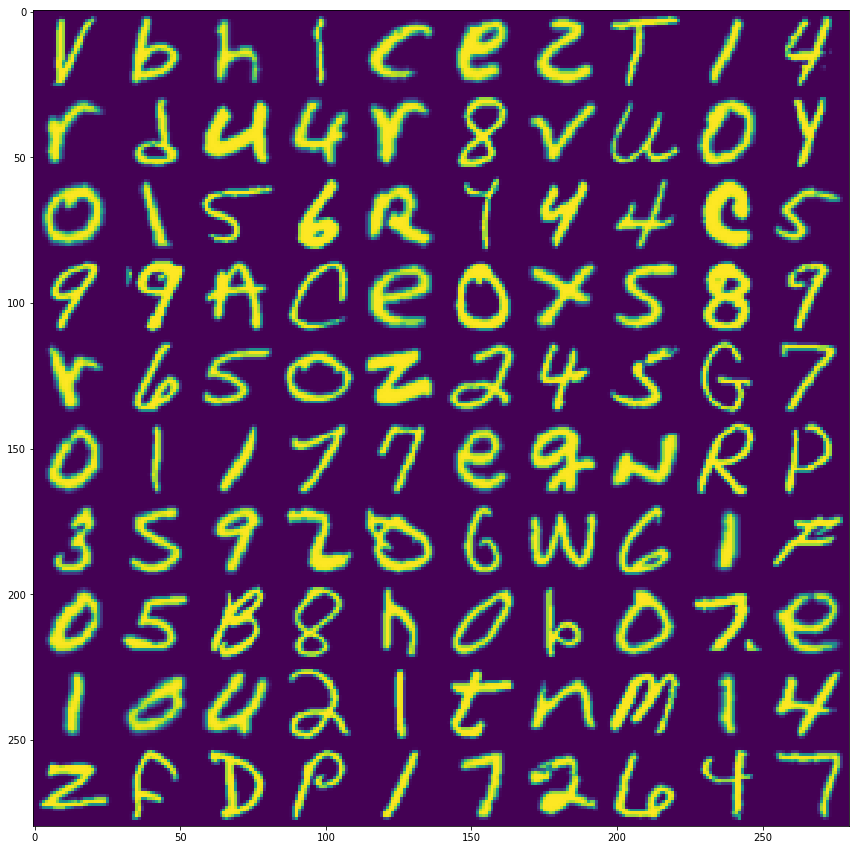

In [18]:
#train input
imshow(x_train[0:100])

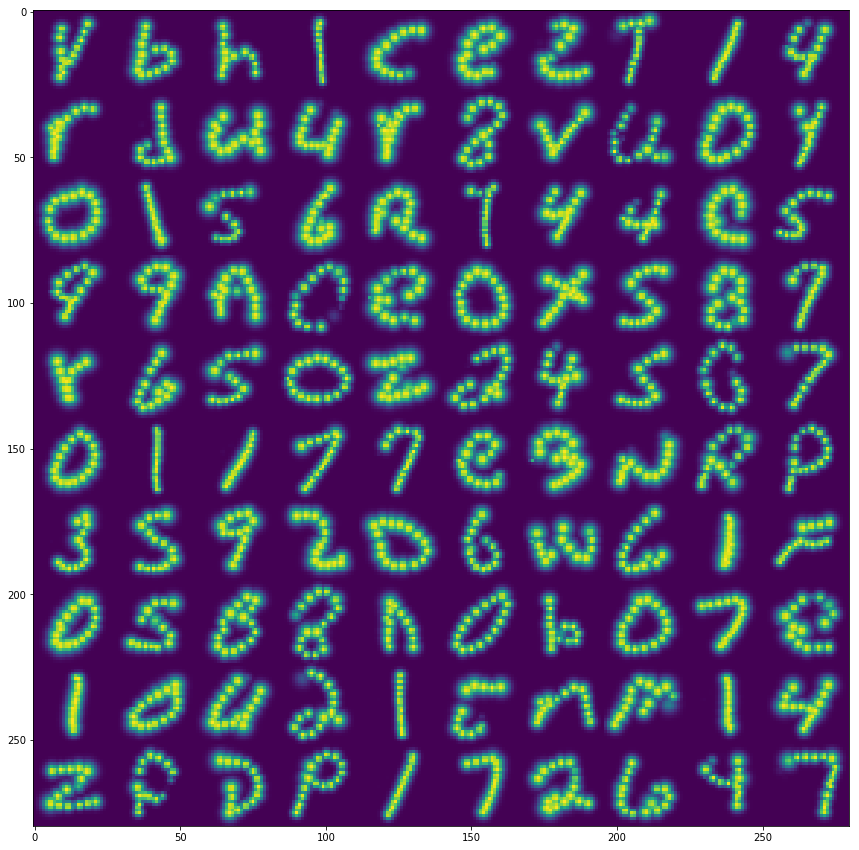

In [19]:
#train output
imshow(sess.run(Y, feed_dict={X:x_train[:100]}))

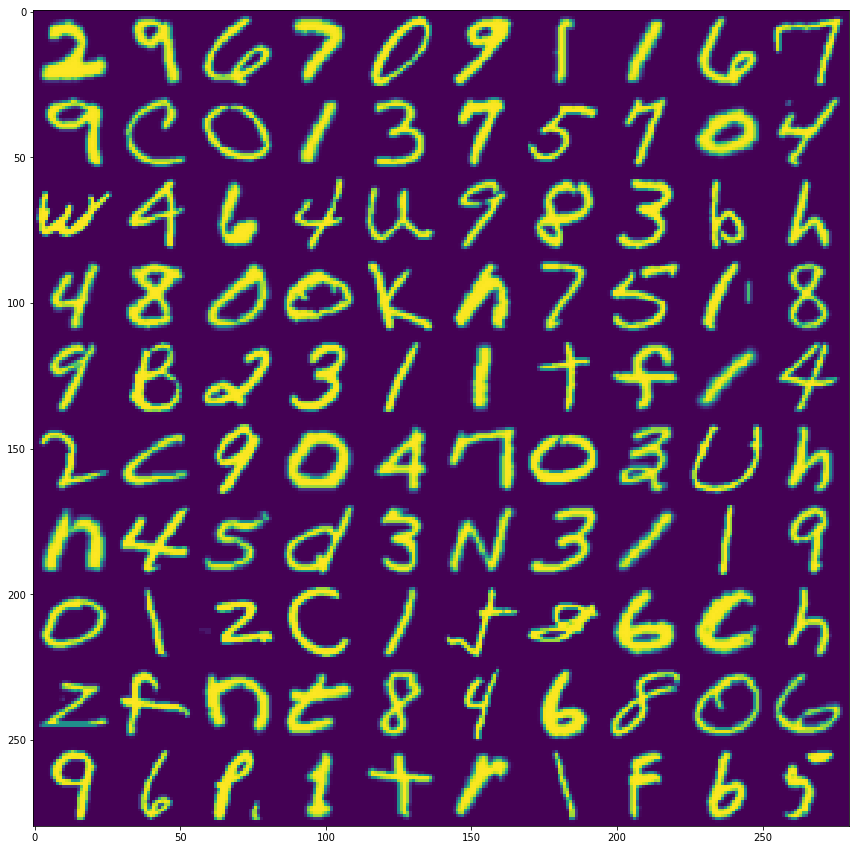

In [20]:
#test input
imshow(x_test[0:100])

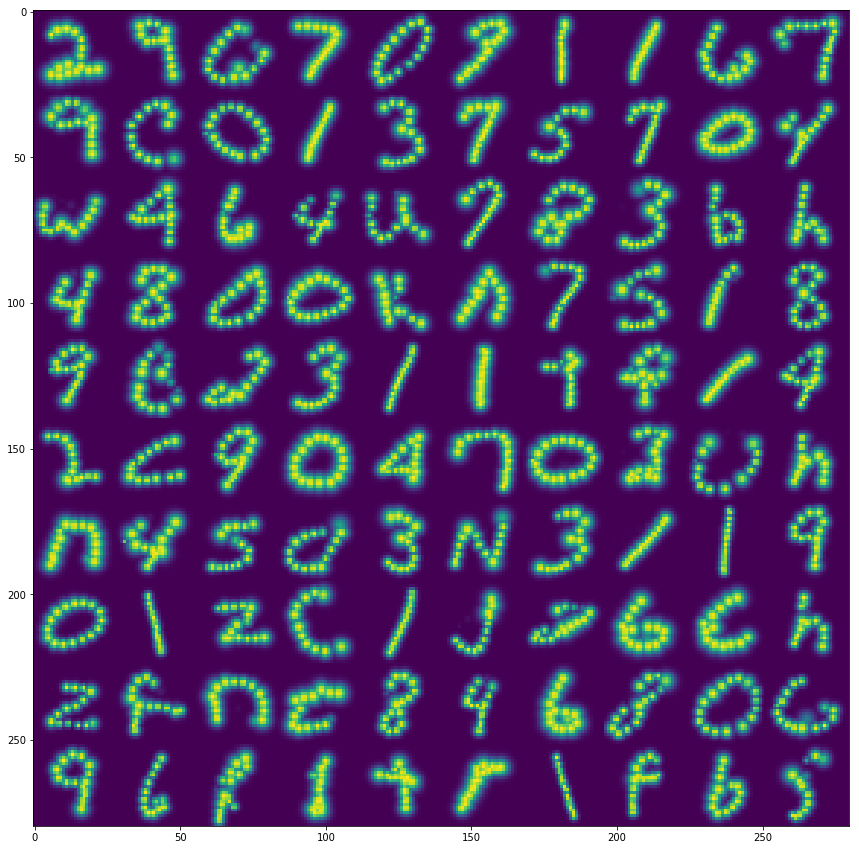

In [21]:
#test output
imshow(sess.run(Y, feed_dict={X:x_test[:100]}))

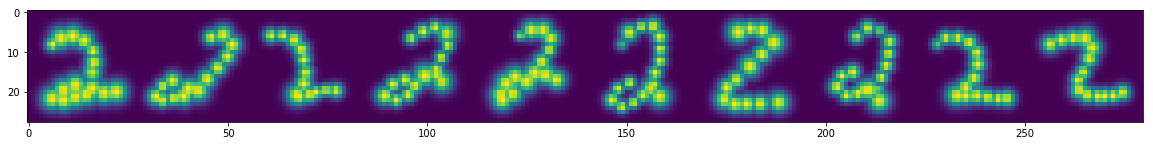

In [22]:
inp = x_test[y_test == 2][:10]
imshow(sess.run(Y, feed_dict={X:inp}))

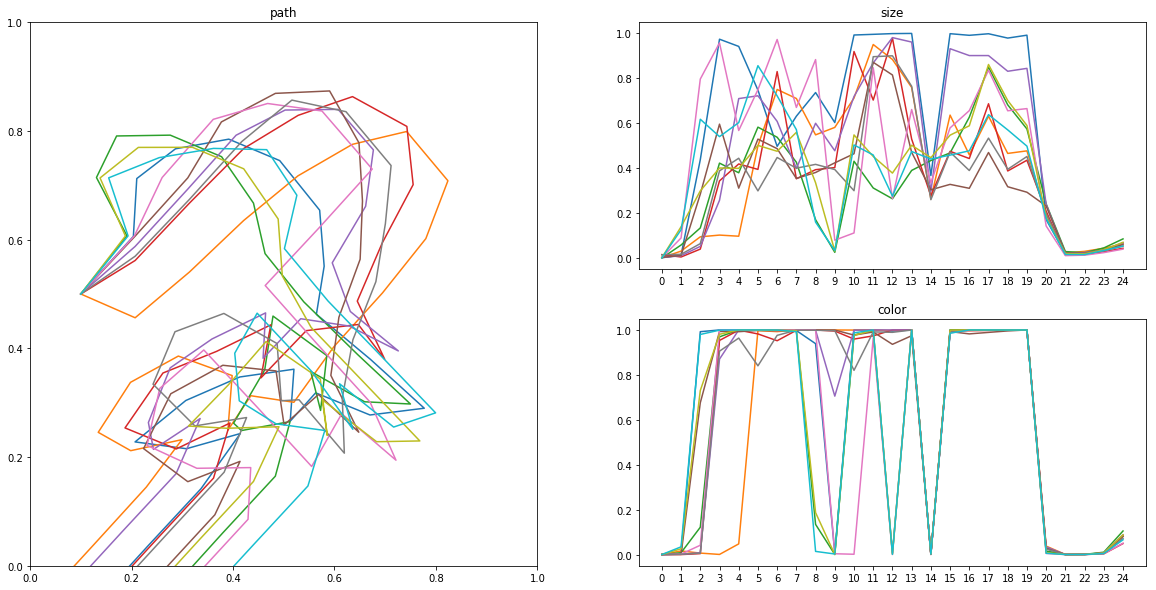

In [23]:
posy, posx, sizes, colors = sess.run([POS_ver, POS_hor, POS_size, POS_color], feed_dict={X:inp})
posy = 1. - np.squeeze(posy).T
posx = np.squeeze(posx).T
sizes = np.squeeze(sizes).T
colors = np.squeeze(colors).T

fig = plt.figure(figsize=(20, 10))
ax1 = plt.subplot(121)
ax1.set_title('path')
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 1))
ax1.plot(posx, posy)
ax2 = plt.subplot(222)
ax2.set_title('size')
ax2.set_xticks(range(points))
ax2.plot(sizes)
ax3 = plt.subplot(224)
ax3.set_title('color')
ax3.set_xticks(range(points))
ax3.plot(colors)
plt.show()

Errors: 7447 of 10000. Accuracy: 25.53 on 10 clusters(labeled samples).


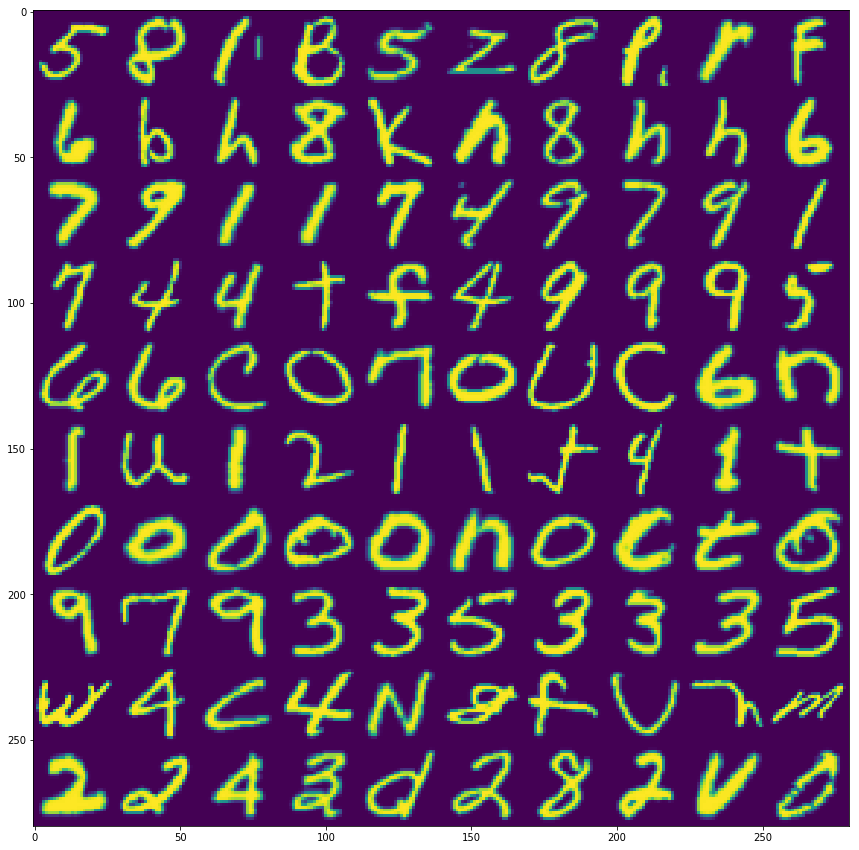

In [24]:
#clustering input
num_clusters = 10
cluster = KMeans(num_clusters)
res = cluster.fit_predict(x_test)
err = np.sum([(res == c).sum() - np.bincount(y_test[res == c]).max() for c in range(num_clusters)])
print('Errors: {} of {}. Accuracy: {} on {} clusters(labeled samples).'.format(err, test_samples, (test_samples - err) / test_samples * 100, num_clusters))
imshow(np.stack([x_test[res == c][:10] for c in range(num_clusters)]))

In [247]:
#clustering 
res = cluster.fit_predict(sess.run(tf.reshape(tf.concat([VELO_ver, VELO_hor, POS_color], axis=2), [test_samples, -1]), feed_dict={X:x_test}))

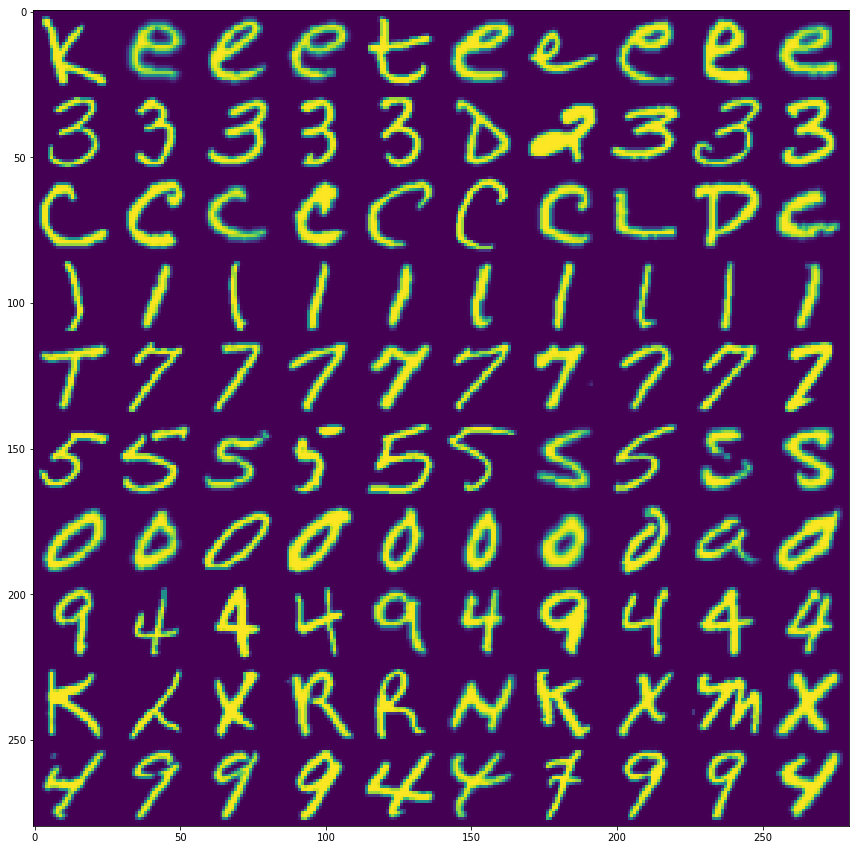

In [248]:
imshow(np.stack([x_test[res == c][:10] for c in range(10)]))

In [249]:
err = np.sum([(res == c).sum() - np.bincount(y_test[res == c]).max() for c in range(num_clusters)])
print('Errors: {} of {}. Accuracy: {} on {} clusters(labeled samples).'.format(err, test_samples, (test_samples - err) / test_samples * 100, num_clusters))

Errors: 4543 of 10000. Accuracy: 54.56999999999999 on 100 clusters(labeled samples).
